In [14]:
import sys
import cv2
import numpy as np
import random
import pytesseract
from IPython.core.display import HTML

from matplotlib import pyplot as plt
%matplotlib inline

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [6]:
%%writefile server.py

from flask import Flask, request, render_template
import requests

app = Flask(__name__)

@app.route('/')
def index():
    html = """
    <h1>안녕하세요</h1>    
    """
    return  html

datas= [45.7, 45, 10, 70.8]

@app.route('/signal')
def signal():
    global datas
    datas.append(request.args.get("data"))
    return  str(datas)

@app.route('/view')
def view():
    global datas
    
    lables=[i+1for i in range(len(datas))]
    
    ctx= {"title":"그래프", 
          "lables":lables,
         "data":datas,
         }
    
    return render_template("view.html", ctx=ctx)

if __name__ == '__main__':
     app.run(host='0.0.0.0', debug=True, port=8000)      



Overwriting server.py


## 템플릿 매칭
- 입력 영상에서 작은 크기의 부분 영상 위치를 찾아내고 싶은 경우 사용: 템플릿과 원본영상 차이 확인
- matchTemplate : TM_SQDIFF_NORMED 정규화된 제곱차 매칭방법(조명에 취약해 잘 안씀) / TM_CCORR : 상관관계 크면  
- TM_CCOEFF 가장 많이 사용 :상관계수 매칭 방법

In [7]:
img = cv2.imread('circuit.bmp', cv2.IMREAD_COLOR)
templ = cv2.imread('crystal.bmp', cv2.IMREAD_COLOR)

img = img + (50, 50, 50)

noise = np.zeros(img.shape, np.int32)
cv2.randn(noise, 0, 10)
img = cv2.add(img, noise, dtype=cv2.CV_8UC3)

# res = cv2.matchTemplate(img, templ, cv2.TM_CCOEFF_NORMED)
res = cv2.matchTemplate(img, templ, cv2.TM_SQDIFF_NORMED)

res_norm = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

minv, maxv, minloc, maxloc = cv2.minMaxLoc(res)
print('maxv:', maxv)
print('minv:', minv)

(th, tw) = templ.shape[:2] #(높이 tw폭)을 가져와서
# cv2.rectangle(img, maxloc, (maxloc[0] + tw, maxloc[1] + th), (0, 0, 255), 2)
cv2.rectangle(img, minloc, (minloc[0] + tw, minloc[1] + th), (0, 0, 255), 2)

cv2.imshow('templ', templ)
cv2.imshow('res_norm', res_norm)
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

#maxv가 1이면 같다는뜻

maxv: 0.7718188762664795
minv: 0.14207376539707184


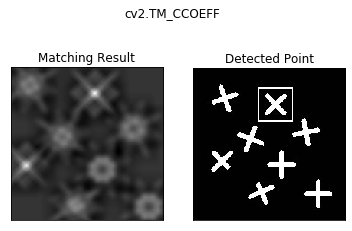

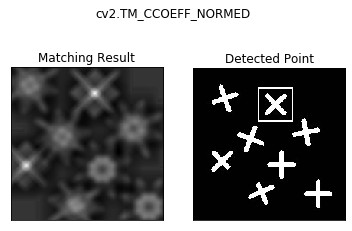

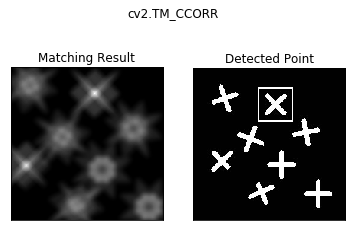

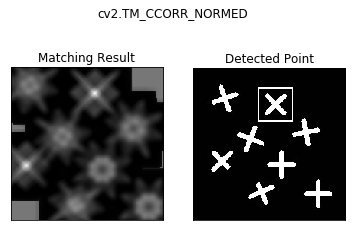

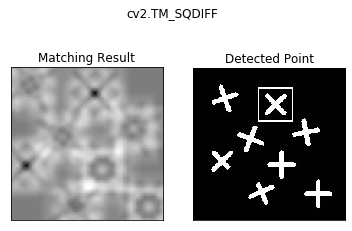

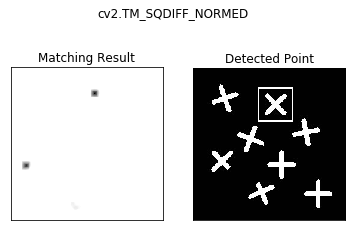

In [8]:
img = cv2.imread('cross.jpg',0)
img2 = img.copy()
template = cv2.imread('template.jpg',0)
w, h = template.shape[::-1]


# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)


    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc



    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)


    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

- 하나가 아닌 2개이상 찾아보기할 때는 : min max로 안되고 threshold 사용해야함
- np.where (res>= threshold)

In [20]:
img_rgb = cv2.imread('input2.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('template2.jpg', 0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.68 #0.68정도의 유사도 갖고있는 애들 뽑는것
loc = np.where(res >= threshold)

In [24]:
# print(loc)

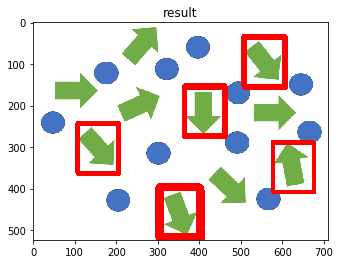

In [22]:
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

imshow('result', img_rgb)

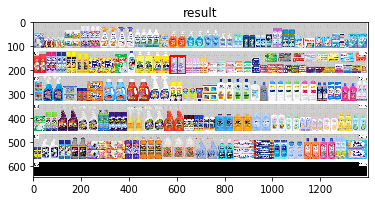

In [23]:
img_rgb = cv2.imread('input4.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('template4.png', 0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.68 #0.68정도의 유사도 갖고있는 애들 뽑는것
loc = np.where(res >= threshold)

for pt in zip(*loc[::-1]):  #2개를 하나로 묶을때 사용
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

imshow('result', img_rgb)

- zip (예:# for pt in zip(*loc[::-1])

In [28]:
a= loc[::-1]
print(a[0])
print(a[1])
# for pt in zip(*loc[::-1]):
    
a= [1,2,3,4,5,7]
b=['a','b','c','d','e','f']

for i in range(len(a)):
    print(a[i], b[i]) #인덱스 이용 자동으로 넣어주는방법

for v in a:
    print(v) #여기서는 값 동시에 가져올수가 없음,, -> zip으로 묶어 한 쌍으로 만듦
    
for v in zip(a,b):
    print(v[0],v[1])

[571 572 604 605 570 571 572 573 602 603 604 605 571 572 603 604]
[140 140 140 140 141 141 141 141 141 141 141 141 142 142 142 142]
1 a
2 b
3 c
4 d
5 e
7 f
1
2
3
4
5
7
1 a
2 b
3 c
4 d
5 e
7 f


In [29]:
# * : 데이터들을 언팩(분할)하는 역할 ex *[1,2,3]-> 1,2,3 로우 단위로 있는 값들 언패킹
a= [[1, 2, 3 ],
    [4,5,6]]
for v in zip(*a): 
    print(v)
    print(v[0])

(1, 4)
1
(2, 5)
2
(3, 6)
3


In [30]:
print(a)
for v in a:
    print(v)

for (i, v) in enumerate(a):
    print(i, v)
    
for k in enumerate(a):
    print(k[0],k[1])
    

[[1, 2, 3], [4, 5, 6]]
[1, 2, 3]
[4, 5, 6]
0 [1, 2, 3]
1 [4, 5, 6]
0 [1, 2, 3]
1 [4, 5, 6]


In [ ]:
def fun(a,b,c):
    print(a,b,c)

fun(1,4,5)
fun(*[1,4,5]) #-> fun(1,4,5) 이렇게 변환시켜줌

scale, rotate 10도정도씩 바꿔가며 실험해보는것 

In [ ]:
# 왈도 찾기
img_rgb = cv2.imread('find_waldo.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('waldo.png', 0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.5
loc = np.where(res >= threshold)
print(loc)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 2)

imshow('result', img_rgb)

In [ ]:
# 도형 찾기
img_rgb = cv2.imread('input3.png')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('template_s.png', 0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.4
loc = np.where(res >= threshold)

for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

imshow('result', img_rgb)

## 캐스케이드 분류기와 얼굴 검출
- 유사 하르(harr-like) 필터: 검은부분과 흰부분에서 

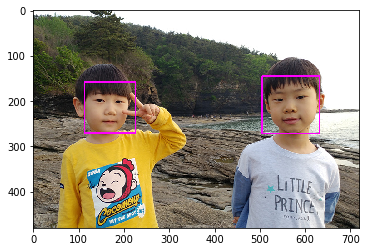

In [61]:
src = cv2.imread('kids.png')
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)

imshow("", src)

In [63]:
print(faces)
print(src.shape)

[[504 145 126 126]
 [113 158 112 112]]
(480, 720, 3)


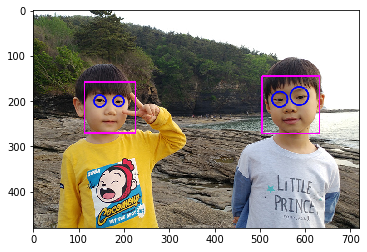

In [64]:
src = cv2.imread('kids.png')
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')


faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
    faceROI = src[y1:y1 + h1, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)
    for (x2, y2, w2, h2) in eyes:
            center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
            cv2.circle(faceROI, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)
imshow("", src)

In [65]:
src = cv2.imread('face04.jpg')
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = classifier.detectMultiScale(src)

In [66]:
print(faces)
print(src.shape)

[[332 274  96  96]
 [ 28 258  97  97]
 [ 40  67  77  77]
 [345  48  91  91]
 [ 44 479  84  84]
 [343 486  91  91]
 [131 444 124 124]]
(658, 627, 3)


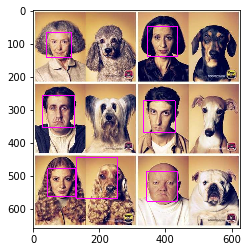

In [67]:
for (x, y, w, h) in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow("", src)

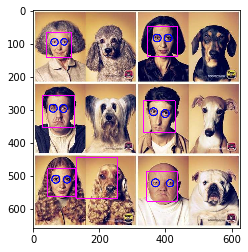

In [68]:
src = cv2.imread('face04.jpg')
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')

faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
    faceROI = src[y1:y1 + h1, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)
    for (x2, y2, w2, h2) in eyes:
        center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
        cv2.circle(faceROI, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow("", src)

In [4]:
#비디오 인식
cap = cv2.VideoCapture(0)

face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')
               
while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)
        
    for (x1, y1, w1, h1) in faces:
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
        
        faceROI = gray[y1:y1 + h1, x1:x1 + w1]
        cv2.imshow("",faceROI)
        
        eyes = eye_classifier.detectMultiScale(faceROI)
        for (x2, y2, w2, h2) in eyes:
            center = (int(x1+ x2 + w2 / 2), int(y1 +y2 + h2 / 2))
            cv2.circle(frame, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)
    
    cv2.imshow('frame', frame)                
    if cv2.waitKey(10) == 27:
        break

cap.release()        
cv2.destroyAllWindows()

- 한글 깨짐, 스마트폰에서의 화면 크기 html 코드-> 별도의 html 파일에 입력

meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">


<form  action="/upload" method="post" enctype="multipart/form-data">
    <input type="file" name="file1" accept="images/*" capture="camera">
    <input type="submit" value="전송">
</form>      

In [19]:
%%writefile server.py

import cv2
from flask import Flask, request, render_template, make_response
app = Flask(__name__)

face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')


@app.route('/')
def index():
    return  render_template("face.html")

@app.route('/upload', methods=["post"])
def upload():
    f = request.files['file1']   
    filename = "./static/" + f.filename
    f.save(filename)    
    
    img = cv2.imread(filename)    
    img = cv2.resize(img, dsize=(0, 0), fx=0.25, fy=0.25)        
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)
        
    for (x1, y1, w1, h1) in faces:
        cv2.rectangle(img, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
        
        faceROI = gray[y1:y1 + h1, x1:x1 + w1]
        cv2.imshow('face', faceROI)                
        
        eyes = eye_classifier.detectMultiScale(faceROI)
        for (x2, y2, w2, h2) in eyes:
            center = (int(x1+ x2 + w2 / 2), int(y1 +y2 + h2 / 2))
            cv2.circle(img, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)
    
    
    retval, buffer = cv2.imencode('.jpg', img)
    
    
    
    response = make_response(buffer.tobytes())
    response.headers['Content-Type'] = 'image/jpg'
    
    return response

    
    
if __name__ == '__main__':
     app.run(host='0.0.0.0', debug=True, port=8000)      

Overwriting server.py


## QR코드 검출

In [24]:
detector= cv2.QRCodeDetector()
frame= cv2.imread("acronet.png")
info, points, _= detector.detectAndDecode(frame)

print(info)
print(points.shape)
print(points)

http://www.acronet.kr/24987
(1, 4, 2)
[[[200.      200.     ]
  [858.97565 200.     ]
  [867.      859.     ]
  [200.      859.     ]]]


In [25]:
# qr코드 3개 연이어 인식ㄱㅏ능한지->에러: 인식 못함
detector= cv2.QRCodeDetector()
frame= cv2.imread("3.png")
info, points, _= detector.detectAndDecode(frame)

print(info)
print(points.shape)
print(points)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# pip install qrcode (생성)
# pip install pyzbar
# pip install pyqrcode

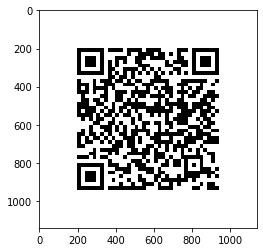

In [38]:
import qrcode

qr= qrcode.QRCode(version=2, box_size=20, border=10)
keyword = "python"
url = f'https://search.kyobobook.co.kr/web/search?vPstrKeyWord={keyword}&orderClick=LAG'

qr.add_data(url)

qr.make()

img= qr.make_image(fill_color="black", back_color="white")

plt.imshow(img, cmap='gray')

img.save("myurl.png")

In [40]:
from pyzbar.pyzbar import decode
from PIL import Image

# image= cv2.imread('myurl.png')
image = cv2.imread('barcode.jpg')

code= decode(image)

print(code)

[Decoded(data=b'https://www.rawpixel.com', type='QRCODE', rect=Rect(left=35, top=35, width=154, height=155), polygon=[Point(x=35, y=35), Point(x=35, y=190), Point(x=189, y=190), Point(x=189, y=35)])]


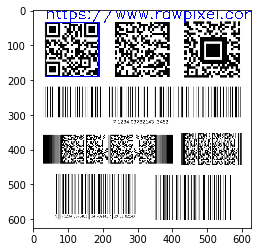

In [41]:
for barcode in code:
    (x,y,w,h)= barcode.rect
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
 
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
 
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
        1.5, (0, 0, 255), 2)
 
   
plt.imshow(image)

In [42]:
%%writefile server.py
import cv2
import numpy as np
from pyzbar.pyzbar import decode

from flask import Flask, request, render_template, make_response
app = Flask(__name__)

face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')


@app.route('/')
def index():
    return  render_template("face.html")

@app.route('/upload', methods=["post"])
def upload():
    f = request.files['file1']   
    filename = "./static/" + f.filename
    f.save(filename)            
    #img = cv2.imdecode(np.fromstring(f.read(), np.uint8), cv2.IMREAD_UNCHANGED)
    img = cv2.imread(filename)    
    #img = cv2.resize(img, dsize=(0, 0), fx=0.25, fy=0.25)        
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)
    
    if len(faces) > 0 :   
        for (x1, y1, w1, h1) in faces:
            cv2.rectangle(img, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)

            faceROI = gray[y1:y1 + h1, x1:x1 + w1]
            cv2.imshow('face', faceROI)                

            eyes = eye_classifier.detectMultiScale(faceROI)
            for (x2, y2, w2, h2) in eyes:
                center = (int(x1+ x2 + w2 / 2), int(y1 +y2 + h2 / 2))
                cv2.circle(img, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)

        retval, buffer = cv2.imencode('.jpg', img)  


        response = make_response(buffer.tobytes())
        response.headers['Content-Type'] = 'image/jpg'

        return response    
    
    code = decode(img)    
    url  = code[0].data.decode("utf-8")    
    
    return f"<a href={url}>QR코드가기</a>" 
    
    #return  f"<script> alert('이동합니다.'); window.location.href='{url}'; </script>"
    
    
    
def gen():
    """Video streaming generator function."""
    while True:
        read_return_code, frame = vc.read()
        encode_return_code, image_buffer = cv2.imencode('.jpg', frame)
        io_buf = io.BytesIO(image_buffer)
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + io_buf.read() + b'\r\n')


@app.route('/video_feed')
def video_feed():
    """Video streaming route. Put this in the src attribute of an img tag."""
    return Response(
        gen(),
        mimetype='multipart/x-mixed-replace; boundary=frame'
    )




if __name__ == '__main__':
     app.run(host='0.0.0.0', debug=True, port=8000)      

Overwriting server.py
